# Clusturing

In [16]:
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"]="1"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [17]:
#set the data folder's path
data_path="data/"

In [18]:
Customers_df=pd.read_csv(os.path.join(data_path,"Customers.csv"))
Transactions_df=pd.read_csv(os.path.join(data_path,"Transactions.csv"))

In [4]:
Customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [5]:
Transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [6]:
#Merging
transactions = Transactions_df.groupby("CustomerID").agg({"Quantity": "sum","TotalValue": "sum"}).reset_index()
Merged_data = pd.merge(Customers_df, transactions, on="CustomerID", how="inner")

## Data Preprocessing

In [7]:
Rle = LabelEncoder()
Merged_data["Region"] = Rle.fit_transform(Merged_data["Region"])

In [8]:
features = ["Region", "Quantity", "TotalValue"]
data = Merged_data[features]
scaler = StandardScaler()
scaled_data= scaler.fit_transform(data)

## Elbow method to determine optimal no:of clusters(Inertia)

In [9]:
k_range = range(2, 11) 
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(scaled_data) for k in k_range]
inertia = [model.inertia_ for model in kmeans_per_k]

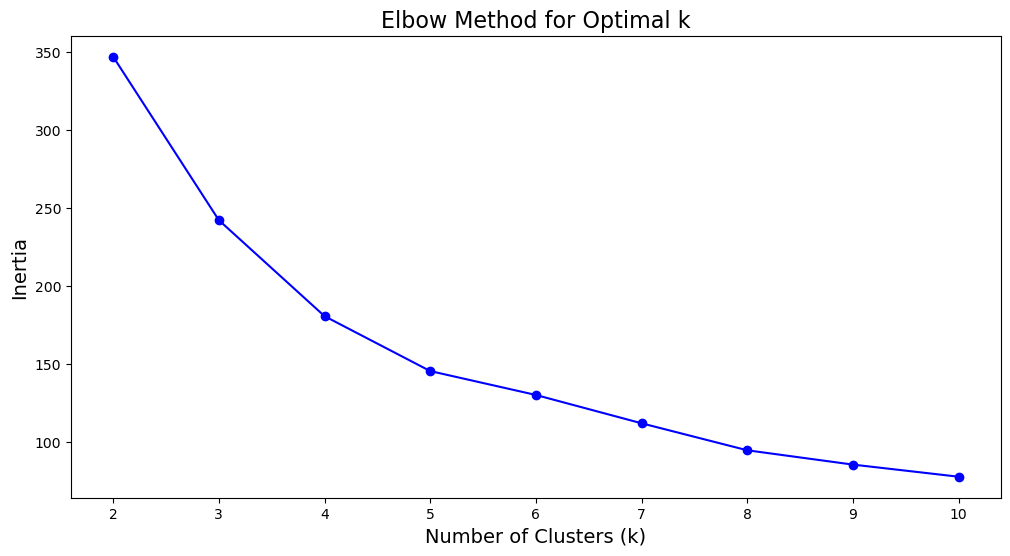

In [10]:
# Plot Inertia
plt.figure(figsize=(12, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.title('Elbow Method for Optimal k', fontsize=16)
plt.show()

## Silhouette Score to ensure the best number of clusters

In [11]:
Silhouette_Scores = [silhouette_score(scaled_data, model.labels_) for model in kmeans_per_k]
best_index = np.argmax(Silhouette_Scores)
best_k = k_range[best_index]
best_score = Silhouette_Scores[best_index]


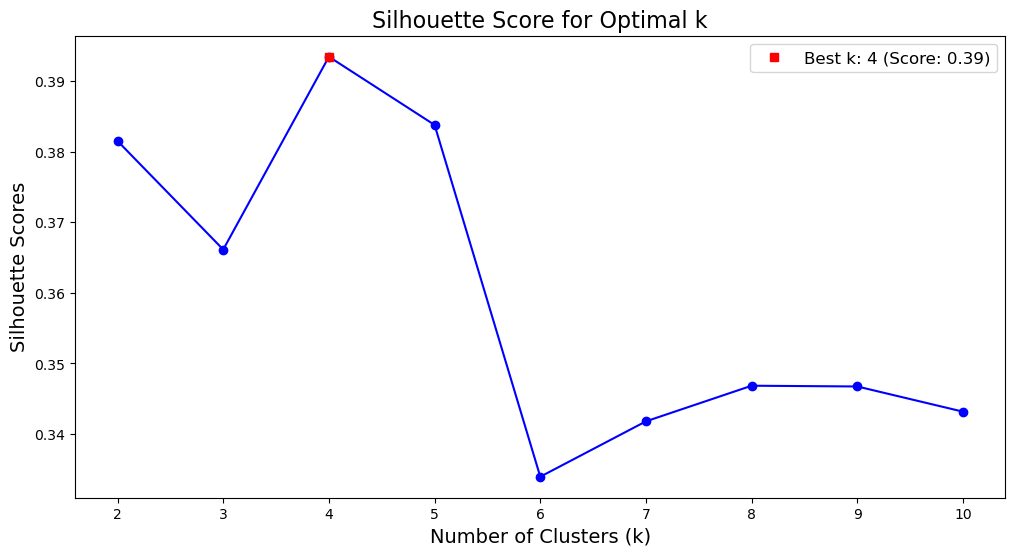

Optimal number of clusters : 4


In [12]:
# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(k_range, Silhouette_Scores, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Silhouette Scores', fontsize=14)
plt.title('Silhouette Score for Optimal k', fontsize=16)
plt.plot(best_k, best_score, 'rs', label=f"Best k: {best_k} (Score: {best_score:.2f})")
plt.legend(fontsize=12)
plt.show()

print(f"Optimal number of clusters : {best_k}")

## Train KMeans Model

In [13]:
best_model = kmeans_per_k[best_index]
Merged_data["Cluster"] = best_model.labels_

for i in range(best_k):
    print(f"Cluster {i + 1} contains: {np.sum(Merged_data['Cluster'] == i)} customers")


Cluster 1 contains: 32 customers
Cluster 2 contains: 59 customers
Cluster 3 contains: 70 customers
Cluster 4 contains: 38 customers


## Evaluate Clustering using DB Index

In [14]:
DB_Index = davies_bouldin_score(scaled_data, Merged_data["Cluster"])
print(f"DB Index: {DB_Index:.2f}")

DB Index: 0.93


## Visualization using TSNE

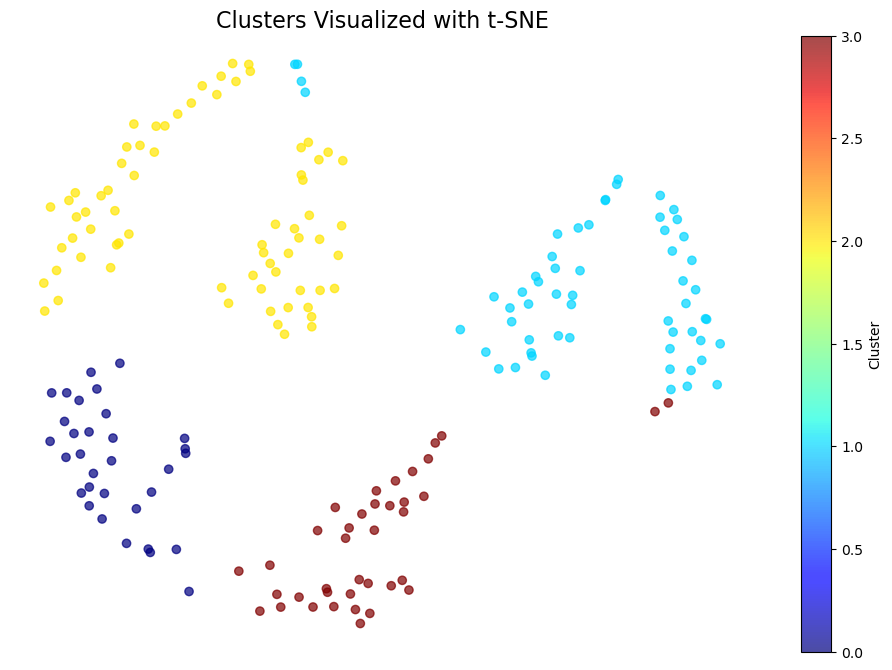

In [15]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_data[:, 0],tsne_data[:, 1], c=Merged_data["Cluster"], cmap="jet", alpha=0.7)
plt.colorbar(label="Cluster")
plt.title("Clusters Visualized with t-SNE", fontsize=16)
plt.axis('off')
plt.show()